In [65]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# xarray to read NETCDF
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [67]:
# Function to take a region and model, then get a stat_clean df for that region and that model
# needs dicts
# needs chirps loaded and other netcdfs opened
def compute_skill_df(chirps_dataset, coord_dict, model_dict):
  """ Takes xarray opened chirps dataset, a coordinates dictionary, and a model dictionary,
      computes a skill assesment dataframe for each region and each model defined in the dicts,
      and returns a dictionary of dataframes.

      coord_dict structure: {
                              'region_1': {'longitude':[min, max], 'latitude':[min, max]},    # Manually defined
                              'region_2': {'longitude': [min, max], 'latitude': [min, max]}.
                              ... etc.
                            }
      model_dict structure: {
                              'model_1': model_1_dataset,   # Opened in xarray and regridded
                              'model_2': model_2_dataset,
                              ... etc.
                            }
      again, ensure that chirps is opened in xarray before passing it through this function

      Output example: {'NMME_South_Sudan': dataframe,
                        'NMME_East_Africa': dataframe,
                        'other_model_ex_South_Sudan': dataframe,
                        'other_model_ex_East_Africa': dataframe,
                        ... etc.
                        }
  """

  stat_dict = {}

  # Set index to be reindex to
  new_lat = np.arange(-90, 90, 0.5)
  new_lon = np.arange(-180, 180, 0.5)

  for model_name, model in model_dict.items():

    model = model.assign_coords(X=(((model.X + 180) % 360) - 180)).sortby(['X'])
    model = model.reindex(X=new_lon, Y=new_lat).ffill('X').ffill('Y')

    for region_name in coord_dict.keys():

      long_min = coord_dict[region_name]['longitude'][0]
      long_max = coord_dict[region_name]['longitude'][1]
      lat_min = coord_dict[region_name]['latitude'][0]
      lat_max = coord_dict[region_name]['latitude'][1]

      # Subset a region based on that model
      current_model_region = (model.sel(X=slice(long_min, long_max), Y=slice(lat_min, lat_max))
                            .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

      # Interpolate and subset CHIRPS to match spatial resolution of current model and region
      chirps_region = (chirps_dataset.sel(latitude=slice(lat_min - 0.5, lat_max + 0.5), longitude=slice(long_min - 0.5, long_max + 0.5)) # 0.5 degrees of resolution must be added for interpolation
                          .interp_like(current_model_region, method='nearest'))

      # Calculate realized dates for CanESM5, convert to dataframe
      current_model_region_df = current_model_region.to_dataframe().reset_index()
      current_model_region_df['realization time'] = current_model_region_df['date of prediction'] + (current_model_region_df['lead time'] * 30).astype('timedelta64[D]')
      current_model_region_df['month'] = current_model_region_df['realization time'].dt.month
      current_model_region_df['year'] = current_model_region_df['realization time'].dt.year

      # Convert CHIRPS to dataframe
      chirps_region_df = chirps_region.to_dataframe().reset_index()
      chirps_region_df['month'] = chirps_region_df['time'].dt.month
      chirps_region_df['year'] = chirps_region_df['time'].dt.year

      # Merge CHIRPS and CanESM5 dataframe
      current_region_merged_df = current_model_region_df.merge(current_model_region_df, how='left', left_on=['month', 'year', 'latitude', 'longitude'], right_on=['month', 'year', 'latitude', 'longitude']).dropna()

      # Drop date of prediction, latitude, longitude
      current_region_merged_df = current_region_merged_df.drop(['realization time', 'date of prediction', 'latitude', 'longitude', 'year', 'time'], axis=1)

      # Make calculations on the merged dataframe for plotting
      corr_clean = current_region_merged_df.groupby(['month', 'lead time', 'M']).corr(method='spearman').drop('precip', axis = 1).droplevel(level=3).reset_index()
      corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

      stat_current_region = (current_region_merged_df.drop(['realization_time', 'time'], axis = 1)
              .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
      stat_current_region.columns = stat_current_region.columns.droplevel()
      stat_current_region.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
      stat_current_region_clean = stat_current_region.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
      stat_current_region_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
      stat_current_region_clean['conditional bias'] = stat_current_region_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
      stat_current_region_clean['unconditional bias'] = stat_current_region_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
      stat_current_region_clean['potential skill'] = stat_current_region_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
      stat_current_region_clean = stat_current_region_clean.drop(['pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
      stat_current_region_clean['skill score'] = stat_current_region_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
      stat_current_region_clean = stat_current_region_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
      stat_current_region_clean['region'] = region_name
      stat_current_region_clean['model'] = model_name
      stat_dict[f"{model_name}_{region_name}"] = stat_current_region_clean

  return stat_dict


In [68]:
# Example usage

# Opening all netCDF files
NMME = xr.open_dataset('/content/drive/My Drive/capstone_data/NMME/prec.CanESM5.1991.mon_Apr.nc')
other_model_ex = xr.open_dataset('/content/drive/My Drive/capstone_data/NMME/prec.CanESM5.1991.mon_Sep.nc')
chirps = xr.open_dataset('/content/drive/My Drive/capstone_data/region_avg_month_ts/chirps-v2.0.monthly.nc')

# Define Dictionaries

# Coordinate Dictionary
region_dict = {
    'South_Sudan': {'longitude':[3.5, 12.5], 'latitude':[25, 35]},
    'East_Africa': {'longitude': [-3.5, 8], 'latitude': [38, 50]}
}

# Model Dictionary
model_dict = {
    'NMME': NMME,
    'other_model_ex': other_model_ex
}

# call the function, this computes the stat df for all regions in the dict for each model in the dict respectively
nmme_stat_all_models_all_regions = compute_skill_df(chirps, region_dict, model_dict)

# Takes the dictionary of data frames from compute_skill_df, and combines them
nmme_stat_all_models_all_regions_df = pd.concat(nmme_stat_apr.values())

# View combined df
nmme_stat_all_models_all_regions_df

,month,lead time,conditional bias,unconditional bias,potential skill,skill score,region,model
0,1,9.5,0.863299,0.344074,0.929000,-0.278373,South_Sudan,NMME
1,2,10.5,0.859574,0.309305,0.942930,-0.225949,South_Sudan,NMME
2,3,11.5,0.821088,0.808884,0.913968,-0.716004,South_Sudan,NMME
3,4,0.5,0.785904,0.797113,0.830822,-0.752196,South_Sudan,NMME
4,5,1.5,0.792856,3.973421,0.849304,-3.916973,South_Sudan,NMME
5,6,2.5,0.658937,3.482188,0.713176,-3.427948,South_Sudan,NMME
6,7,3.5,0.157900,3.265740,0.168169,-3.255471,South_Sudan,NMME
7,8,4.5,0.296944,10.428680,0.344756,-10.380868,South_Sudan,NMME
8,9,5.5,0.523221,2.310404,0.572160,-2.261464,South_Sudan,NMME
9,10,6.5,0.799376,1.278748,0.840764,-1.237359,South_Sudan,NMME


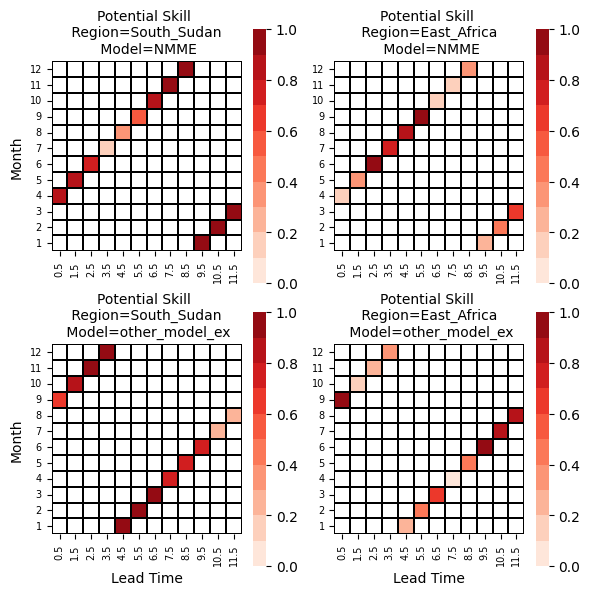

In [70]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=1,
                cmap=sns.color_palette('Reds', 10),
                linewidths=0.1, linecolor='black')
    plt.xticks(np.arange(0.5, 12.5, 1))  # Set xticks explicitly
    plt.gca().set_xticklabels(np.arange(0.5, 12.5, 1))  # Set xticklabels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(nmme_stat_all_models_all_regions_df, col='region', row='model', sharex=False, sharey=False)
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'potential skill', square = True)

fg.set_titles('Potential Skill \n Region={col_name} \n Model={row_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()